<a href="https://colab.research.google.com/github/manami-bunbun/ES_analysis/blob/main/ES_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 就職活動ES
## Mecabによる形態素分析

### インストール

In [1]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3==0.996.5
!pip install unidic-lite
!pip install japanize-matplotlib

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,146 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking swig (3.0.12

In [2]:
import MeCab
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. 前処理

### 1.1. 形態素解析

文などを分割して、言語で意味を持つ最小単位である形態素の列に変換し、その品詞を推定することを形態素解析と呼びます。

In [3]:
tagger = MeCab.Tagger('-Ochasen')
node = tagger.parse("デジタルコンサルタント職では、常に最新のデジタルテクノロジーを学び、活用することができるからです。")
print(node)

デジタル	デジタル	デジタル	名詞-一般		
コンサルタント	コンサルタント	コンサルタント	名詞-一般		
職	ショク	職	名詞-接尾-一般		
で	デ	で	助詞-格助詞-一般		
は	ハ	は	助詞-係助詞		
、	、	、	記号-読点		
常に	ツネニ	常に	副詞-一般		
最新	サイシン	最新	名詞-一般		
の	ノ	の	助詞-連体化		
デジタル	デジタル	デジタル	名詞-一般		
テクノロジー	テクノロジー	テクノロジー	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
学び	マナビ	学ぶ	動詞-自立	五段・バ行	連用形
、	、	、	記号-読点		
活用	カツヨウ	活用	名詞-サ変接続		
する	スル	する	動詞-自立	サ変・スル	基本形
こと	コト	こと	名詞-非自立-一般		
が	ガ	が	助詞-格助詞-一般		
できる	デキル	できる	動詞-自立	一段	基本形
から	カラ	から	助詞-接続助詞		
です	デス	です	助動詞	特殊・デス	基本形
。	。	。	記号-句点		
EOS



### 1.2. MeCabを用いて文を形態素に分割

先ほどの形態素解析の結果を用いて、日本語の文を形態素に分割する関数を定義します。

In [4]:
def tokenize(sentence):
    """日本語の文を形態素の列に分割する関数

    :param sentence: str, 日本語の文
    :return tokenized_sentence: list of str, 形態素のリスト
    """
    node = tagger.parse(sentence)
    node = node.split("\n")
    tokenized_sentence = []
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            # 文が終わったら終了
            break
        elif not(feature[0] == "、" or feature[0] == "。" or feature[0] == " ") :
           if  feature[3].startswith(('形容詞', '名詞','副詞')):
        # 分割された形態素を追加
                print(feature)
                tokenized_sentence.append(feature[0])
    return tokenized_sentence

In [5]:
#test for関数
tokenize("坊主が屏風に上手に坊主の絵を描いた")

['坊主', 'ボウズ', '坊主', '名詞-一般', '', '']
['屏風', 'ビョウブ', '屏風', '名詞-一般', '', '']
['上手', 'ジョウズ', '上手', '名詞-形容動詞語幹', '', '']
['坊主', 'ボウズ', '坊主', '名詞-一般', '', '']
['絵', 'エ', '絵', '名詞-一般', '', '']


['坊主', '屏風', '上手', '坊主', '絵']

In [6]:
def load_data(path):
    """読み込むための関数

    :param path: str, パス
    :return text: list of list of str, 各文がトークナイズされた
    """
    text = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            line = tokenize(line)
            text.append(line)
    return text

### 1.3. データ読み込み

'Data_consultant.txt': データコンサルタント志望理由(n=9)


In [7]:
text = load_data('Data_consultant.txt')

['デジタル', 'デジタル', 'デジタル', '名詞-一般', '', '']
['コンサルタント', 'コンサルタント', 'コンサルタント', '名詞-一般', '', '']
['職', 'ショク', '職', '名詞-接尾-一般', '', '']
['常に', 'ツネニ', '常に', '副詞-一般', '', '']
['最新', 'サイシン', '最新', '名詞-一般', '', '']
['デジタル', 'デジタル', 'デジタル', '名詞-一般', '', '']
['テクノロジー', 'テクノロジー', 'テクノロジー', '名詞-一般', '', '']
['活用', 'カツヨウ', '活用', '名詞-サ変接続', '', '']
['こと', 'コト', 'こと', '名詞-非自立-一般', '', '']
['私', 'ワタシ', '私', '名詞-代名詞-一般', '', '']
['大学', 'ダイガク', '大学', '名詞-一般', '', '']
['情報', 'ジョウホウ', '情報', '名詞-一般', '', '']
['系', 'ケイ', '系', '名詞-接尾-一般', '', '']
['主', 'オモ', '主', '名詞-形容動詞語幹', '', '']
['それら', 'ソレラ', 'それら', '名詞-代名詞-一般', '', '']
['魅力', 'ミリョク', '魅力', '名詞-一般', '', '']
['今後', 'コンゴ', '今後', '名詞-副詞可能', '', '']
['可能', 'カノウ', '可能', '名詞-形容動詞語幹', '', '']
['性', 'セイ', '性', '名詞-接尾-一般', '', '']
['これから', 'コレカラ', 'これから', '副詞-助詞類接続', '', '']
['社会', 'シャカイ', '社会', '名詞-一般', '', '']
['人', 'ジン', '人', '名詞-接尾-一般', '', '']
['上', 'ウエ', '上', '名詞-非自立-副詞可能', '', '']
['常に', 'ツネニ', '常に', '副詞-一般', '', '']
['新しい', 'アタラシイ', '新しい', '形容詞-自立', '形容詞

In [8]:
# 分割された結果の例
print(text)

[['デジタル', 'コンサルタント', '職', '常に', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', '私', '大学', '情報', '系', '主', 'それら', '魅力', '今後', '可能', '性', 'これから', '社会', '人', '上', '常に', '新しい', '技術', '姿勢', '大切', '自身', '成長', 'ため', '常に', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', 'デジタル', 'コンサルタント', '職', '志望'], [], ['最先端', 'デジタル技術', '専門', '性', 'それ', '課題', '解決', '新た', '価値', '創造', '私', 'ゼミ', '研究', 'IoT', 'AI', '最先端', 'デジタル技術', '今後', '社会', '非常', '可能', '性', 'こと', '関心', 'ため', 'デジタル技術', '専門', '性', '顧客', '課題', '解決', '新しい', '社会', '変革', '寄与'], [], ['私', 'デジタル', 'コンサルタント', '一', '志望', '職種', '理由', '私', '貴社', '実現', 'こと', '最適', '職種', '私', '企業', '激しく', '変化', '時代', '対応', 'ため', 'デジタル', '化', '必須', 'ため', '最先端', 'デジタル', '幅広く', '高度', '知見', '常に', 'それら', '応用', '必要', 'それ', '同時に', '普遍', '的', '方法', '論', '身', '顧客', '新た', '価値', '提供'], [], ['顧客', 'テクノロジー', '何', 'コンサルタント', '昨今', '社会', '情勢', 'テクノロジー', '活用', 'ＤＸ', '化', '推進', '私', 'あまりに', '推進', 'テクノロジー', '手段', '目的', '危惧', '中', '顧客', 'テクノロジー', '何', '実現', 'の', '何', '必要', 'の', 'コンサルタント'], [], ['自身', '研究', '無限', 

### 1.4. 辞書構築
コーパス（文書データ）に登場する単語にユニークなIDを振るために辞書を構築します。

全ての単語を辞書に登録するとしばしば語彙数が膨大(1万〜100万)になりメモリが足りなくなることがあるので、

単語の出現頻度で足切りして辞書のサイズを制限するということをします。

NLPではほぼ必ず必要になる手順です。

In [9]:
class Vocab(object):
    def __init__(self, word2id={}):
        """
        word2id: 単語(str)をインデックス(int)に変換する辞書
        id2word: インデックス(int)を単語(str)に変換する辞書
        """
        self.word2id = dict(word2id)
        self.id2word = {v: k for k, v in self.word2id.items()}    
        
    def build_vocab(self, sentences, min_count=3):
        # 各単語の出現回数の辞書を作成する
        word_counter = {}
        for sentence in sentences:
            for word in sentence:
                word_counter[word] = word_counter.get(word, 0) + 1

        # min_count回以上出現する単語のみ語彙に加える
        for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
            if count < min_count:
                break
            _id = len(self.word2id)
            self.word2id.setdefault(word, _id)
            self.id2word[_id] = word 



In [10]:
#単語の数カウンと
sen = []
for row in range(len(text)):
    for col in range(len(text[row])):
        sen.append(text[row][col])


print(sen)

['デジタル', 'コンサルタント', '職', '常に', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', '私', '大学', '情報', '系', '主', 'それら', '魅力', '今後', '可能', '性', 'これから', '社会', '人', '上', '常に', '新しい', '技術', '姿勢', '大切', '自身', '成長', 'ため', '常に', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', 'デジタル', 'コンサルタント', '職', '志望', '最先端', 'デジタル技術', '専門', '性', 'それ', '課題', '解決', '新た', '価値', '創造', '私', 'ゼミ', '研究', 'IoT', 'AI', '最先端', 'デジタル技術', '今後', '社会', '非常', '可能', '性', 'こと', '関心', 'ため', 'デジタル技術', '専門', '性', '顧客', '課題', '解決', '新しい', '社会', '変革', '寄与', '私', 'デジタル', 'コンサルタント', '一', '志望', '職種', '理由', '私', '貴社', '実現', 'こと', '最適', '職種', '私', '企業', '激しく', '変化', '時代', '対応', 'ため', 'デジタル', '化', '必須', 'ため', '最先端', 'デジタル', '幅広く', '高度', '知見', '常に', 'それら', '応用', '必要', 'それ', '同時に', '普遍', '的', '方法', '論', '身', '顧客', '新た', '価値', '提供', '顧客', 'テクノロジー', '何', 'コンサルタント', '昨今', '社会', '情勢', 'テクノロジー', '活用', 'ＤＸ', '化', '推進', '私', 'あまりに', '推進', 'テクノロジー', '手段', '目的', '危惧', '中', '顧客', 'テクノロジー', '何', '実現', 'の', '何', '必要', 'の', 'コンサルタント', '自身', '研究', '無限', '可能', '性', '実感', 'IT', '技

In [13]:
import collections
c = collections.Counter(sen)
print(c.most_common(20))

[('こと', 14), ('デジタル', 12), ('コンサルタント', 9), ('常に', 9), ('テクノロジー', 8), ('私', 7), ('性', 7), ('社会', 5), ('最新', 4), ('技術', 4), ('自身', 4), ('ため', 4), ('最先端', 4), ('専門', 4), ('課題', 4), ('解決', 4), ('顧客', 4), ('企業', 4), ('身', 4), ('の', 4)]


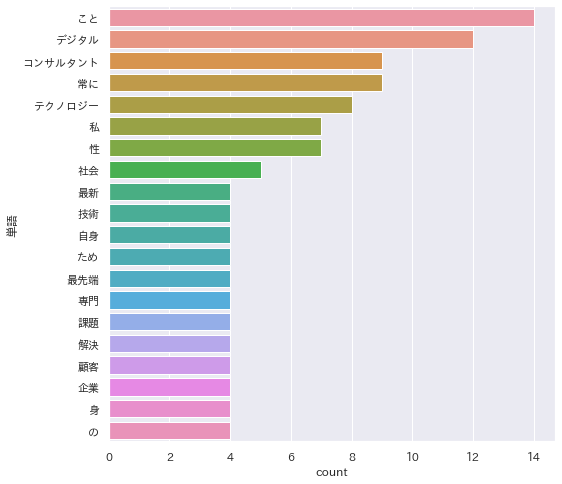

In [14]:
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt
 
sns.set(context="notebook",font='IPAexGothic')
fig = plt.subplots(figsize=(8, 8))
 
plt.ylabel("単語")
sns.countplot(y=sen,order=[i[0] for i in c.most_common(20)])

In [ ]:
print(sen)
print(text)

['デジタル', 'コンサルタント', '職', '常に', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', '私', '大学', '情報', '系', '主', 'それら', '魅力', '今後', '可能', '性', 'これから', '社会', '人', '上', '常に', '新しい', '技術', '姿勢', '大切', '自身', '成長', 'ため', '常に', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', 'デジタル', 'コンサルタント', '職', '志望', '最先端', 'デジタル技術', '専門', '性', 'それ', '課題', '解決', '新た', '価値', '創造', '私', 'ゼミ', '研究', 'IoT', 'AI', '最先端', 'デジタル技術', '今後', '社会', '非常', '可能', '性', 'こと', '関心', 'ため', 'デジタル技術', '専門', '性', '顧客', '課題', '解決', '新しい', '社会', '変革', '寄与', '私', 'デジタル', 'コンサルタント', '一', '志望', '職種', '理由', '私', '貴社', '実現', 'こと', '最適', '職種', '私', '企業', '激しく', '変化', '時代', '対応', 'ため', 'デジタル', '化', '必須', 'ため', '最先端', 'デジタル', '幅広く', '高度', '知見', '常に', 'それら', '応用', '必要', 'それ', '同時に', '普遍', '的', '方法', '論', '身', '顧客', '新た', '価値', '提供', '顧客', 'テクノロジー', '何', 'コンサルタント', '昨今', '社会', '情勢', 'テクノロジー', '活用', 'ＤＸ', '化', '推進', '私', 'あまりに', '推進', 'テクノロジー', '手段', '目的', '危惧', '中', '顧客', 'テクノロジー', '何', '実現', 'の', '何', '必要', 'の', 'コンサルタント', '自身', '研究', '無限', '可能', '性', '実感', 'IT', '技

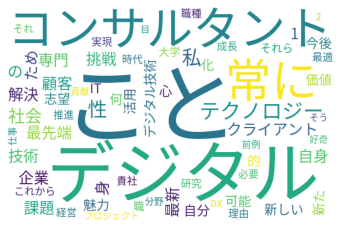

In [15]:
from wordcloud import WordCloud

cloud_data = c

fpath = "NotoSansJP-Regular.otf"
cloud = WordCloud(font_path=fpath,background_color='white',width=600,height=400,min_font_size=15).fit_words(cloud_data)

plt.imshow(cloud)
plt.axis('off')
plt.show()



## ID辞書生成


In [ ]:
# 特殊なトークンとそのIDは事前に定義しておきます。
PAD_TOKEN = '<PAD>' # あとで説明するpaddingに使います
UNK_TOKEN = '<UNK>' # 辞書にない単語は全てこのUNKトークンに置き換えます。(UNKの由来はunkownです)
PAD = 0 # <PAD>のID
UNK = 1 # <UNK>のID

In [ ]:
# 辞書の初期化
word2id = {
    PAD_TOKEN: PAD,
    UNK_TOKEN: UNK,
}

# 辞書に含める単語の最低出現回数
# 今回はコーパスのサイズが小さいので、全ての単語を辞書に含めることにします
MIN_COUNT = 1

In [ ]:
vocab = Vocab(word2id=word2id)
vocab.build_vocab(text, min_count=MIN_COUNT)

In [ ]:
def sentence_to_ids(vocab, sen):
    """
    単語のリストをIDのリストに変換する関数

    :param vocab: class `Vocab` object
    :param sen: list of str, 文を分かち書きして得られた単語のリスト
    :return out: list of int, 単語IDのリスト
    """
    out = [vocab.word2id.get(word, UNK) for word in sen] # 辞書にない単語にはUNKのIDを割り振ります
    return out

In [ ]:
id_text = [sentence_to_ids(vocab, sen) for sen in text]

In [ ]:
def pad_seq(seq, max_length):
    """Paddingを行う関数

    :param seq: list of int, 単語のインデックスのリスト
    :param max_length: int, バッチ内の系列の最大長
    :return seq: list of int, 単語のインデックスのリスト
    """
    seq += [PAD for i in range(max_length - len(seq))]
    return seq

## SkipgramによるWord2Vec


In [ ]:
class DataLoaderSG(object):
    """Skipgramのためのデータローダー"""
    def __init__(self, text, batch_size, window=3):
        """
        :param text: list of list of int, 単語をIDに変換したデータセット
        :param batch_size: int, ミニバッチのサイズ
        :param window: int, 周辺単語と入力単語の最大距離
        """
        self.text = text
        self.batch_size = batch_size
        self.window = window
        self.s_pointer = 0 # データセット上を走査する文単位のポインタ
        self.w_pointer = 0 # データセット上を走査する単語単位のポインタ
        self.max_s_pointer = len(text) # データセットに含まれる文の総数

    def __iter__(self):
        return self

    def __next__(self):
        batch_X = []
        batch_Y = []

        while len(batch_X) < self.batch_size:
            sen = self.text[self.s_pointer]
            
            # Skipgramでは入力が1単語
            word_X = sen[self.w_pointer]

            # 出力は周辺単語
            start = max(0, self.w_pointer - self.window)
            word_Y = sen[start:self.w_pointer] + \
                sen[self.w_pointer + 1:self.w_pointer + self.window + 1]
            word_Y = pad_seq(word_Y, self.window * 2)

            batch_X.append(word_X)
            batch_Y.append(word_Y)
            self.w_pointer += 1

            if self.w_pointer >= len(sen):
                self.w_pointer = 0
                self.s_pointer += 1
                if self.s_pointer >= self.max_s_pointer:
                    self.s_pointer = 0
                    raise StopIteration

        batch_X = torch.tensor(batch_X, dtype=torch.long, device=device)
        batch_Y = torch.tensor(batch_Y, dtype=torch.long, device=device)

        return batch_X, batch_Y

In [ ]:
class Skipgram(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        """
        :param vocab_size: int, 語彙の総数
        :param embedding_size: int, 単語埋め込みベクトルの次元
        """
        super(Skipgram, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.linear = nn.Linear(self.embedding_size, self.vocab_size, bias=False)

    def forward(self, batch_X, batch_Y):
        """
        :param batch_X: torch.Tensor(dtype=torch.long), (batch_size,)
        :param batch_Y: torch.Tensor(dtype=torch.long), (batch_size, window*2)
        :return loss: torch.Tensor(dtype=torch.float), Skipgramのloss
        """
        emb_X = self.embedding(batch_X) # (batch_size, embedding_size)
        lin_X = self.linear(emb_X) # (batch_size, vocab_size)
        log_prob_X = F.log_softmax(lin_X, dim=-1) # (batch_size, vocab_size)
        log_prob_X = torch.gather(log_prob_X, 1, batch_Y) # (batch_size, window*2)
        # paddingした単語のlossは計算しないようにマスクをかけます(=lossの該当部分を0にします)
        log_prob_X = log_prob_X * (batch_Y != PAD).float() # (batch_size, window*2)
        loss = log_prob_X.sum(1).mean().neg()
        return loss

In [ ]:
# Hyper Parameters
batch_size = 5 # ミニバッチのサイズ
n_batches = 5 # 今回学習するミニバッチの数
vocab_size = len(vocab.word2id) # 語彙の総数
embedding_size = 5 # 各単語に割り当てるベクトルの次元数

In [ ]:
sg = Skipgram(vocab_size, embedding_size).to(device)
optimizer_sg = optim.Adam(sg.parameters())
dataloader_sg = DataLoaderSG(id_text, batch_size)

In [ ]:
start_at = time.time()
for batch_id, (batch_X, batch_Y) in enumerate(dataloader_sg):
    loss = compute_loss(sg, (batch_X, batch_Y), optimizer=optimizer_sg, is_train=True)
    if batch_id % 100 == 0:
        print("batch:{}, loss:{:.4f}".format(batch_id, loss))
    if batch_id >= n_batches:
        break
end_at = time.time()
print("Elapsed time: {:.2f} [sec]".format(end_at - start_at))